In [22]:
import pandas as pd
import os
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

In [23]:
odir = './demux/analysis'
os.makedirs(odir, exist_ok=True)

ifile_demux_results = './demux/results/SMC.demuxed_reads.CPM.tsv'
ifile_sample_conditions = './smc_sample_conditions.txt'



### Read in data, incorporate sample information, and save into a new file

In [24]:

demux = pd.read_table(ifile_demux_results)
sample_conditions = pd.read_table(ifile_sample_conditions)
demux['sample'] = demux['barcode'].apply(lambda bc: bc.split('_')[0])

demux = pd.merge(demux, sample_conditions, on='sample')

source_map = {
    'ST94_GS211122_hifi_reads' : 'run1',
    'ST94b_cell1-1523-m64152e_220305_042004' : 'run2_cell1',
    'ST94b_cell2-1525-m64152e_220306_103206' : 'run2_cell2',
    'ST94b_cell3-1527-m64152e_220307_164404' : 'run2_cell3',
    }
demux['source'] = demux['file'].map(source_map)
demux.drop(columns=['barcode','file'], inplace=True)
demux = demux[['pbid', 'source', 'sample', 'fl_count', 'cpm',  'donor', 'sex', 'ethnicity/race', 'cell_type', 'condition' ]]
# demux.to_csv(os.path.join(odir, 'SMC.demuxed_with_sample_data.tsv'), sep='\t', index=False)


### Difference in CPM for each individual between treated with FSB vs not treated.


In [25]:
demux_pivot = demux.pivot(index='pbid',columns=['source', 'donor', 'condition'], values='cpm')

sources = demux_pivot.columns.unique(level='source')
source_deltas = {}
for source in sources:
    only_source = demux_pivot.xs(source, level='source', axis=1)
    fbs = only_source.xs('FBS',level='condition', axis=1)
    no_fbs = only_source.xs('NoFBS',level='condition', axis=1)
    delta = fbs.fillna(0) - no_fbs.fillna(0)
    source_deltas[source] = delta
    delta.to_csv(os.path.join(odir, f'SMC.{source}.delta.fsb-nofsb.tsv'), sep='\t')  

### Filtering to only retain samples that are found in majority of replicates for at least N samples.

In [26]:
demux_grouped = demux.groupby(['pbid', 'sample'])
meta = demux_grouped[['donor', 'sex', 'ethnicity/race', 'condition']].first().reset_index()
stats = demux_grouped.agg({
    'fl_count' : ['size', 'mean', 'median', 'min', 'max'],
    'cpm' : ['mean', 'median', 'min', 'max']
})
stats.columns = stats.columns.get_level_values(0) + '.' +  stats.columns.get_level_values(1)
stats.reset_index(inplace=True)
demux_stats = meta.merge(stats, on=['pbid', 'sample'])
demux_stats.rename(columns = {'fl_count.size' : 'count'}, inplace=True)
demux_stats['sample_found'] = 1
demux_stats['sample_found_majority'] = (demux_stats['count'] >= 3) * 1

In [27]:
found_stats = demux_stats.pivot(index='pbid', columns='sample', values='sample_found')
found_stats.fillna(0, inplace=True)
found_stats['total'] = found_stats.sum(axis=1, skipna=True)

found_stats[found_stats['total'] > 2]
found_stats = found_stats.astype(int)



In [31]:
found_stats.groupby('total').size().reset_index(name='number_of_isoforms')

,total,number_of_isoforms
0,1,15895
1,2,69429
2,3,30363
3,4,18010
4,5,12386
5,6,8979
6,7,7081
7,8,5886
8,9,5070
9,10,4714


In [33]:
found_majority_all = demux_stats.pivot(index='pbid', columns='sample', values='sample_found_majority')
found_majority_all.fillna(0, inplace=True)
found_majority_all['total'] = found_majority_all.sum(axis=1, skipna=True)
found_majority_all = found_majority_all.astype(int)


In [34]:
found_majority = found_majority_all[found_majority_all['total'] > 0].sort_values(by='total', ascending=False)

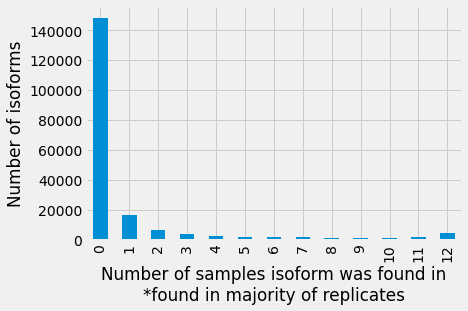

In [35]:

found_majority_all['total'] = found_majority_all['total'].astype(int)
total = found_majority_all.groupby('total').size()
ax = total.plot(kind='bar')
ax.set_xlabel('Number of samples isoform was found in\n*found in majority of replicates')
ax.set_ylabel('Number of isoforms')
plt.savefig(os.path.join(odir, f'SMC.number_of_isoforms_found_majority_replicate.png'), bbox_inches='tight')

In [37]:
total.reset_index(name='x')

,total,x
0,0,148495
1,1,16825
2,2,6539
3,3,3803
4,4,2770
5,5,2171
6,6,1806
7,7,1623
8,8,1471
9,9,1376


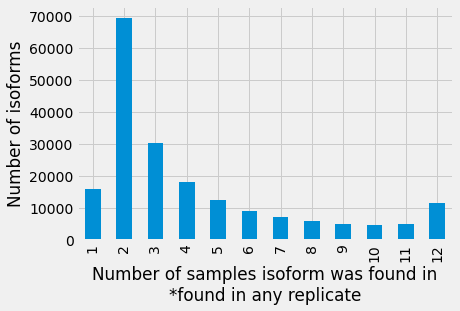

In [10]:
found_stats['total'] = found_stats['total'].astype(int)

ax = found_stats.groupby('total').size().plot(kind='bar')
ax.set_xlabel('Number of samples isoform was found in\n*found in any replicate')
ax.set_ylabel('Number of isoforms')
plt.savefig(os.path.join(odir, f'SMC.number_of_isoforms_found_at_all.png'), bbox_inches='tight')

In [11]:
found_stats.groupby('total').size().reset_index(name='number_of_samples')

,total,number_of_samples
0,1,15895
1,2,69429
2,3,30363
3,4,18010
4,5,12386
5,6,8979
6,7,7081
7,8,5886
8,9,5070
9,10,4714


In [12]:
demux_pivot = demux.pivot(index='pbid',columns=['source', 'donor', 'condition'], values='cpm')
demux_pivot = demux_pivot[demux_pivot.index.isin(found_majority.index)]
sources = demux_pivot.columns.unique(level='source')
source_deltas = {}
for source in sources:
    only_source = demux_pivot.xs(source, level='source', axis=1)
    fbs = only_source.xs('FBS',level='condition', axis=1)
    no_fbs = only_source.xs('NoFBS',level='condition', axis=1)
    delta = fbs.fillna(0) - no_fbs.fillna(0)
    source_deltas[source] = delta
    delta.to_csv(os.path.join(odir, f'SMC.{source}.filtered_found_majority_replicate.delta.fsb-nofsb.tsv'), sep='\t')  

In [13]:
delta

donor,C99,F93,K98,L101,Z89,Z99
pbid,,,,,,
PB.1.10,0.516087,1.548261,-0.516087,0.000000,0.516087,0.000000
PB.1.14,0.000000,0.000000,0.516087,0.000000,0.000000,-0.516087
PB.1.16,0.000000,0.000000,0.516087,0.000000,0.000000,1.032174
PB.1.29,-0.516087,0.000000,-0.516087,0.000000,-0.516087,0.516087
PB.1.3,0.000000,0.000000,0.000000,0.000000,0.000000,-0.516087
...,...,...,...,...,...,...
PB.9992.6,-1.032174,1.548261,-3.096522,-3.612609,4.644783,1.032174
PB.9993.2,0.000000,0.000000,-1.032174,1.032174,-0.516087,1.032174
PB.9993.4,1.032174,-1.548261,-1.032174,-2.580435,0.516087,1.548261


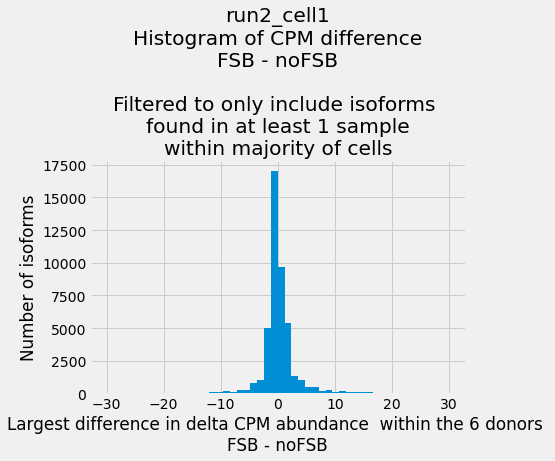

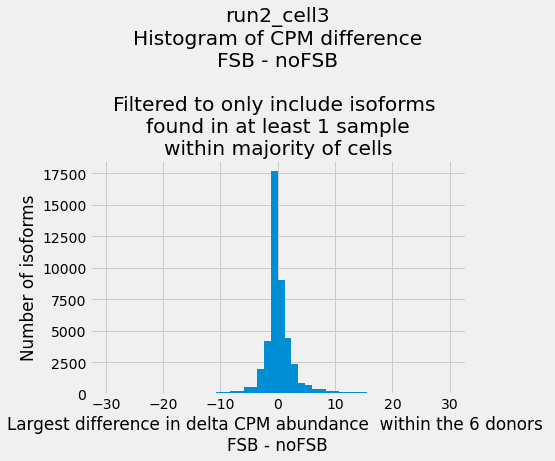

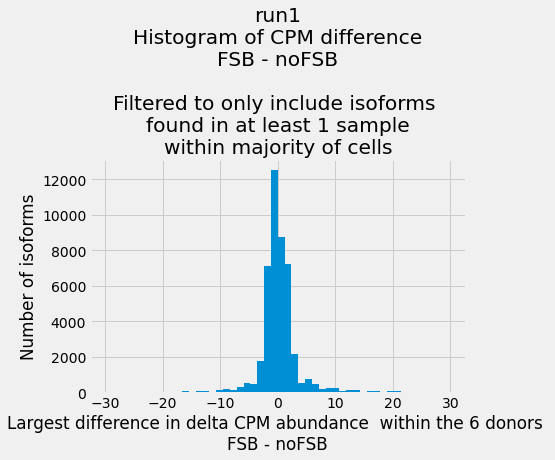

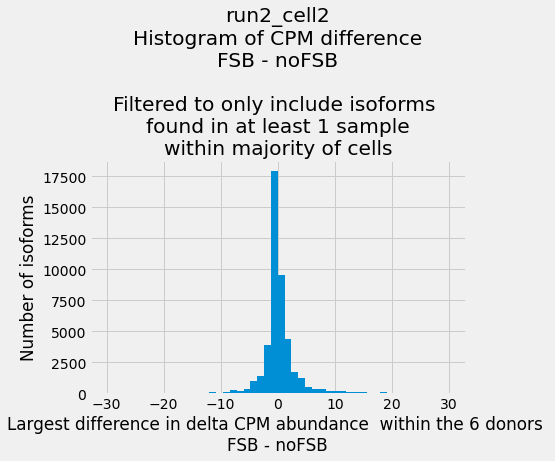

<Figure size 432x288 with 0 Axes>

In [14]:
for source, delta in source_deltas.items():
    delta['max'] = delta.apply(max, axis = 1)
    delta['min'] = delta.apply(min, axis = 1)
    delta['greatest_delta'] = delta.apply(lambda x: x['max'] if abs(x['max']) > abs(x['min']) else x['min'], axis=1)

    
    tmp = delta[delta['greatest_delta'].between(-30, 30)]
    ax = tmp['greatest_delta'].hist(bins=50)
    ax.set_xlabel('Largest difference in delta CPM abundance  within the 6 donors \nFSB - noFSB')
    ax.set_ylabel('Number of isoforms')
    ax.set_title(f'{source}\nHistogram of CPM difference\nFSB - noFSB\n\nFiltered to only include isoforms \nfound in at least 1 sample\nwithin majority of cells')
    plt.savefig(os.path.join(odir, f'SMC.{source}.fsb-fsb.hist.png'), bbox_inches='tight')
    plt.show()
    plt.clf()



In [15]:
found_majority.sort_index()

sample,S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,S11,S12,total
pbid,,,,,,,,,,,,,
PB.1.10,1,0,1,1,0,0,1,0,0,0,0,0,4
PB.1.14,0,0,0,0,0,0,0,1,0,0,0,0,1
PB.1.16,0,0,0,1,0,0,0,0,0,0,1,0,2
PB.1.29,0,0,0,1,0,0,1,0,0,0,0,0,2
PB.1.3,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
PB.9992.6,1,0,0,1,1,1,1,1,1,1,0,1,9
PB.9993.2,0,0,0,0,0,0,0,0,0,0,0,1,1
PB.9993.4,0,1,0,1,1,0,1,0,1,0,1,1,7


In [16]:
found_stats

sample,S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,S11,S12,total
pbid,,,,,,,,,,,,,
PB.1.1,0,0,0,0,0,0,1,0,0,0,0,0,1
PB.1.10,1,0,1,1,1,1,1,1,1,1,1,1,11
PB.1.11,0,0,0,1,0,0,0,0,0,0,0,1,2
PB.1.12,0,1,0,1,0,1,1,0,0,0,0,0,4
PB.1.13,0,0,0,1,0,1,1,1,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
PB.9995.1,0,0,0,1,0,0,0,0,0,0,0,0,1
PB.9996.1,0,0,0,0,0,0,1,1,0,1,0,1,4
PB.9997.1,0,0,0,0,1,0,0,0,0,0,0,1,2


In [17]:
count_stats = demux_stats.pivot(index='pbid', columns='sample', values='count')
count_stats.fillna(0, inplace=True)
count_stats = count_stats.astype(int)

count_stats.head()
sample_ids = sample_conditions['sample'].unique()

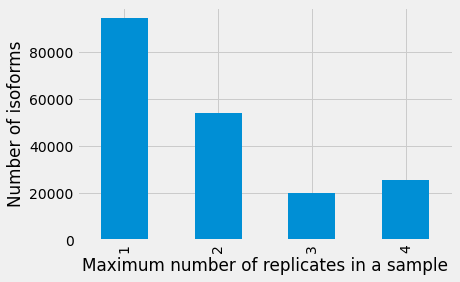

In [18]:

count_stats['max'] = count_stats[sample_ids].apply(max, axis=1)

ax = count_stats.groupby('max').size().plot(kind='bar')
ax.set_xlabel('Maximum number of replicates in a sample')
ax.set_ylabel('Number of isoforms')
plt.savefig(os.path.join(odir,'max_replicates_isoforms_found.png'), bbox_inches='tight' )

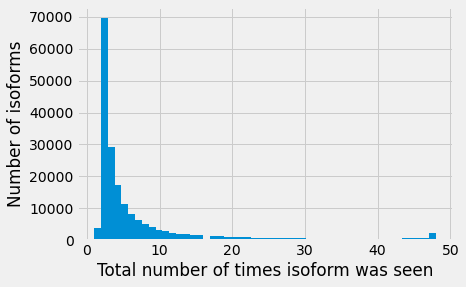

In [19]:
count_stats['total'] = count_stats[sample_ids].apply(sum, axis=1)
ax = count_stats['total'].hist(bins = 50)
ax.set_xlabel('Total number of times isoform was seen')
ax.set_ylabel('Number of isoforms')
plt.savefig(os.path.join(odir,'total_isoform_count.png'), bbox_inches='tight' )

## CPM

In [38]:
demux_stats

,pbid,sample,donor,sex,ethnicity/race,condition,count,fl_count.mean,fl_count.median,fl_count.min,fl_count.max,cpm.mean,cpm.median,cpm.min,cpm.max,sample_found,sample_found_majority
0,PB.1.1,S07,Z99,M,AMR,FBS,2,1.00,1.0,1,1,0.477971,0.477971,0.475280,0.480662,1,0
1,PB.1.10,S01,F93,M,AFR,FBS,4,2.00,2.0,1,3,1.040322,1.066182,0.480662,1.548261,1,1
2,PB.1.10,S03,L101,F,EUR,FBS,4,1.75,1.5,1,3,0.911300,0.869349,0.480662,1.425840,1,1
3,PB.1.10,S04,L101,F,EUR,NoFBS,4,3.25,3.0,2,5,1.742533,1.780779,1.032174,2.376400,1,1
4,PB.1.10,S05,C99,F,AFR,FBS,2,1.00,1.0,1,1,0.611305,0.611305,0.516087,0.706524,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816892,PB.9997.1,S05,C99,F,AFR,FBS,1,1.00,1.0,1,1,0.480662,0.480662,0.480662,0.480662,1,0
816893,PB.9997.1,S12,K98,F,AMR,NoFBS,1,1.00,1.0,1,1,0.516087,0.516087,0.516087,0.516087,1,0
816894,PB.9998.1,S04,L101,F,EUR,NoFBS,2,1.00,1.0,1,1,0.498374,0.498374,0.480662,0.516087,1,0
816895,PB.9999.1,S08,Z99,M,AMR,NoFBS,1,1.00,1.0,1,1,0.475280,0.475280,0.475280,0.475280,1,0


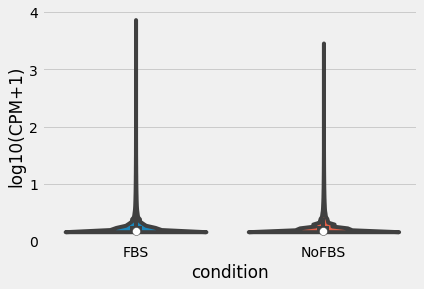

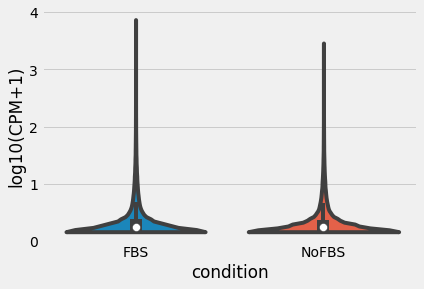

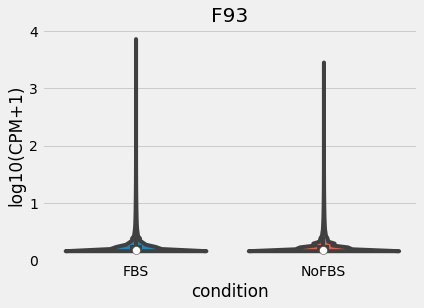

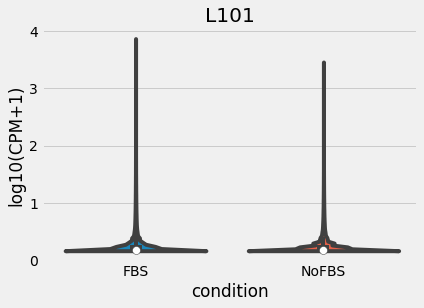

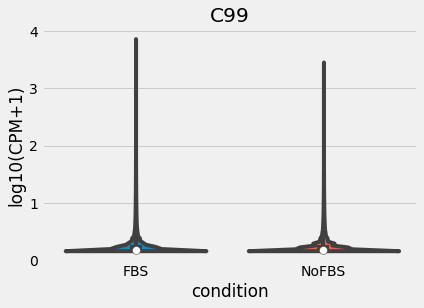

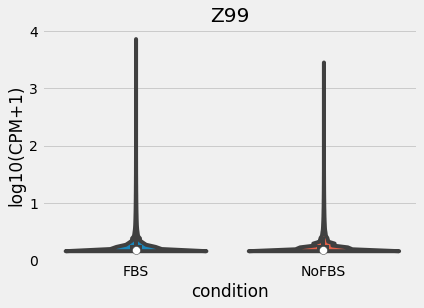

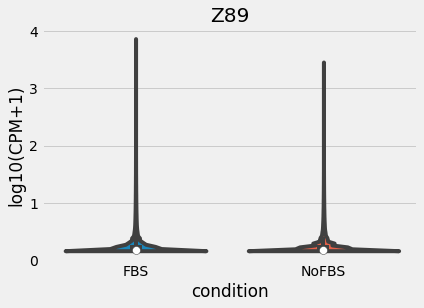

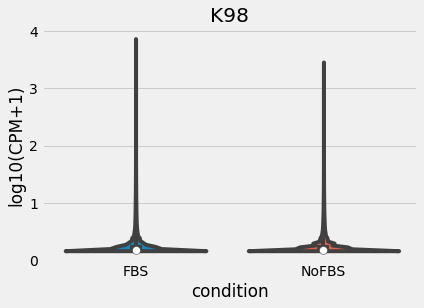

<Figure size 432x288 with 0 Axes>

In [42]:
import seaborn as sns 
import numpy as np
# fig, ax = plt.subplots(figsize = (3,10))

demux_stats['log10(CPM+1)'] = np.log10(demux_stats['cpm.mean'] + 1)
sns.violinplot(data=demux_stats, y = 'log10(CPM+1)', x='condition', cut=0)
plt.savefig(os.path.join(odir, 'violinplot_condition_log_cpm.png'), bbox_inches='tight', )
plt.show()
plt.clf()

sns.violinplot(data=demux_stats[demux_stats['pbid'].isin(found_majority.index)], y = 'log10(CPM+1)', x='condition', cut=0)
plt.savefig(os.path.join(odir, 'major.violinplot_condition_log_cpm.png'), bbox_inches='tight')
plt.show()
plt.clf()


for donor in sample_conditions['donor'].unique():
    donor_demux = demux_stats[demux_stats['donor'] == donor]
    ax = sns.violinplot(data=demux_stats, y = 'log10(CPM+1)', x='condition', cut=0)
    ax.set_title(donor)
    plt.savefig(os.path.join(odir, f'{donor}.violinplot_condition_log_cpm.png'), bbox_inches='tight')
    plt.show()
    plt.clf()


<AxesSubplot:>

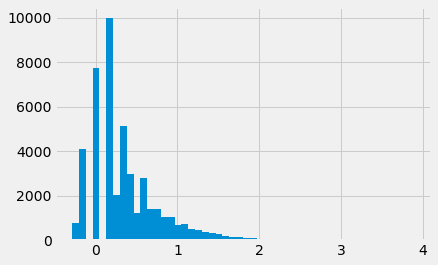

In [21]:
max_cpm[max_cpm.index.isin(found_majority.index)]['log_cpm'].hist(bins = 50)

In [22]:
source_size = demux.groupby(['pbid', 'source']).size().reset_index(name='number_of_cells_isoform_found_in')
source_size = source_size.groupby('pbid').size().reset_index(name='num_cells')

# source_size.groupby('pbid').size().plot(kind='bar')

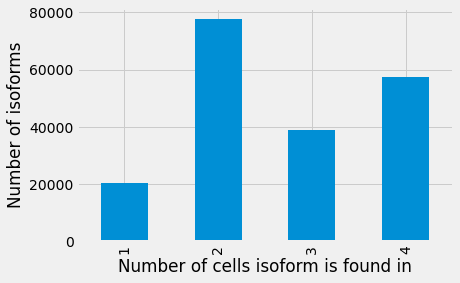

In [23]:
ax = source_size.groupby('num_cells').size().plot(kind='bar')
ax.set_xlabel('Number of cells isoform is found in')
ax.set_ylabel('Number of isoforms')
plt.savefig(os.path.join(odir, 'num_cells_isoform_found.png'), bbox_inches='tight')

In [24]:
a = source_size.groupby('num_cells').size().reset_index(name='num_isoforms')
a

,num_cells,num_isoforms
0,1,20330
1,2,77618
2,3,38929
3,4,57507


In [44]:
demux_pivot

source,run2_cell1,run2_cell3,run1,run2_cell2,run2_cell1,run2_cell3,run1,run2_cell2,run2_cell1,run2_cell3,...,run1,run2_cell2,run2_cell1,run2_cell3,run1,run2_cell2,run2_cell1,run2_cell3,run1,run2_cell2
donor,Z99,Z99,Z99,Z99,F93,F93,F93,F93,L101,L101,...,F93,F93,K98,K98,K98,K98,Z89,Z89,Z89,Z89
condition,FBS,FBS,FBS,FBS,FBS,FBS,FBS,FBS,FBS,FBS,...,NoFBS,NoFBS,NoFBS,NoFBS,NoFBS,NoFBS,NoFBS,NoFBS,NoFBS,NoFBS
pbid,,,,,,,,,,,,,,,,,,,,,
PB.1.1,0.47528,0.480662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PB.1.10,0.47528,0.480662,1.413048,NaN,1.42584,0.480662,0.706524,1.548261,1.42584,0.480662,...,NaN,NaN,NaN,NaN,0.706524,0.516087,NaN,NaN,NaN,0.516087
PB.1.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.480662,NaN,NaN,NaN,NaN,NaN,NaN
PB.1.12,NaN,NaN,NaN,0.516087,NaN,NaN,NaN,NaN,NaN,NaN,...,0.706524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PB.1.13,NaN,0.480662,0.706524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PB.9995.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
grp = demux.groupby(['pbid', 'donor', 'condition'])
average_cpm = grp[['cpm']].apply(np.mean)

In [54]:
cpm_thresholds = [0, 0.5, 1, 2, 3, 4, 5, 10,15, 20, 25]
pivot_data = {}
pivot_stats = []
demux_total = demux.groupby(['pbid','source'])['cpm'].sum().reset_index()
for cpm in cpm_thresholds:
    demux_cpm = demux_total[demux_total['cpm'] >= cpm]
    demux_cpm_pivot = demux_cpm.pivot(index='pbid',columns=['source'], values='cpm')
    pivot_data[cpm] = demux_cpm_pivot
    pivot_stats.append({'cpm': cpm, 'size':len(demux_cpm_pivot)})
    print(f'{cpm}\t{len(demux_cpm_pivot)}')


pivot_stats = pd.DataFrame(pivot_stats)

0	194384
0.5	183808
1	102208
2	51927
3	33862
4	27110
5	22091
10	12823
15	9283
20	7461
25	6218


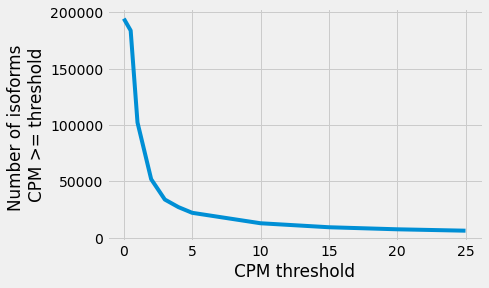

In [64]:
fig, ax = plt.subplots()
ax.plot(pivot_stats['cpm'], pivot_stats['size'])
ax.set_xlabel('CPM threshold')
ax.set_ylabel('Number of isoforms \nCPM >= threshold')
plt.savefig(os.path.join(odir, 'cpm_threshold.png'), bbox_inches='tight')

In [59]:
pivot_stats

,cpm,size
0,0.0,194384
1,0.5,183808
2,1.0,102208
3,2.0,51927
4,3.0,33862
5,4.0,27110
6,5.0,22091
7,10.0,12823
8,15.0,9283
9,20.0,7461
